In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import glob
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras

print(tf.__version__)

batch_size = 32
img_height = 180
img_width = 180

2.7.0


In [2]:
data_dir = 'dataset_lettuce'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

data_dir = 'dataset_lettuce'
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 134 files belonging to 7 classes.
Using 108 files for training.
Found 134 files belonging to 7 classes.
Using 26 files for validation.
['bacterial', 'fungal_downy_mildew', 'fungal_powdery_mildew', 'fungal_septoria_blight', 'fungal_wilt_and_leaf_blight', 'healthy', 'viral']


In [3]:
# print('val_ds: ')
# for element in val_ds:
#   print(element[0].shape)
# #
# print('train_ds: ')
# for element in train_ds:
#   print(element)

In [4]:
# dir = 'dataset_lettuce/'
# print(os.listdir(dir))
# for folder in os.listdir(dir):
#   path = dir + folder
#   for file in os.listdir(path):
#     print(file)
#     img = PIL.Image.open(path + '/' + file).convert('L').resize((28, 28), PIL.Image.ANTIALIAS)
#     # img = np.array(img)
#     img = PIL.Image.open(path + '/' + file)
#     if(img.format != 'JPEG' ):
#       print('!!!!!!!!!!!!!!!!!!!!!!!!!')


    # tf.io.decode_image(img)
    # print('########################################')

# filename_queue = tf.train.string_input_producer(filenames)


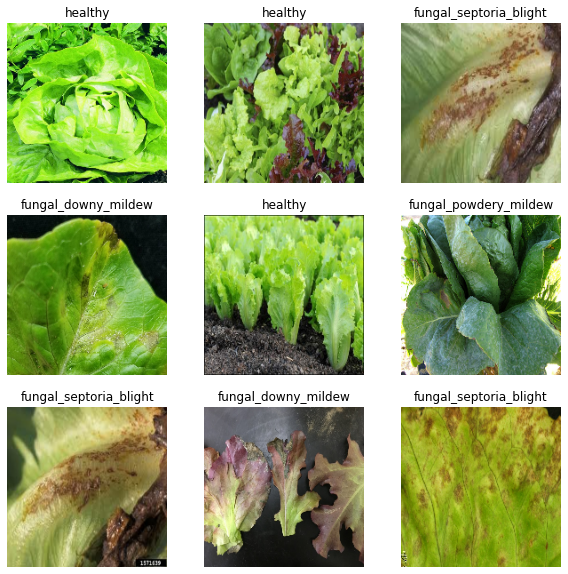

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [8]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [13]:
# Train the model:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
4/4 [==============================] - 40s 401ms/step - loss: 2.4298 - accuracy: 0.2037 - val_loss: 1.8472 - val_accuracy: 0.1538
Epoch 2/10
4/4 [==============================] - 0s 19ms/step - loss: 1.9550 - accuracy: 0.1759 - val_loss: 1.8683 - val_accuracy: 0.1923
Epoch 3/10
4/4 [==============================] - 0s 20ms/step - loss: 1.8639 - accuracy: 0.2407 - val_loss: 1.8544 - val_accuracy: 0.1923
Epoch 4/10
4/4 [==============================] - 0s 22ms/step - loss: 1.7419 - accuracy: 0.2500 - val_loss: 1.7541 - val_accuracy: 0.3077
Epoch 5/10
4/4 [==============================] - 0s 19ms/step - loss: 1.6435 - accuracy: 0.4444 - val_loss: 1.6150 - val_accuracy: 0.3077

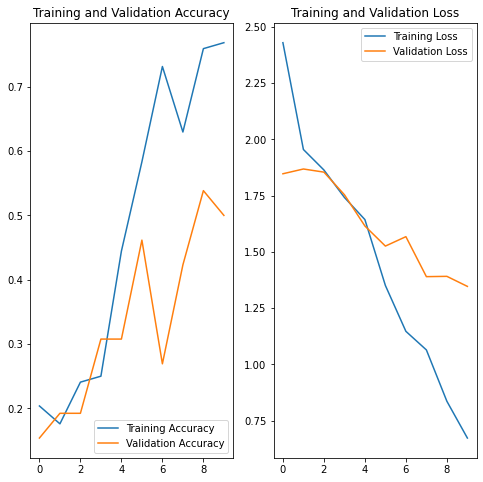

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
lettuce_path = "C:\\Users\\USER\\Desktop\\bacterial_sample0.jpg"
# sunflower_path = tf.keras.utils.get_file('sick_lettuce', origin=sunflower_url)

img = tf.keras.utils.load_img(
    lettuce_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

ind = np.argpartition(score, -7)[-7:]

print("All predictions:")
print('-------------------------\n')
sum = 0
pred_list = []

for el in ind:
  pred = [ class_names[el] ,  float(100 * score[el]) ]
  sum += float(100 * score[el])
  pred_list.append(pred)
  # tf.print(score[el]*100)

pred_list = sorted(pred_list, key = lambda x: x[1])

for pred in pred_list:
  print(pred[0], ' : ', pred[1])

print('\nTotal sum of : ', sum)

This image most likely belongs to fungal_powdery_mildew with a 49.56 percent confidence.
All predictions:
-------------------------

fungal_septoria_blight  :  0.15346917510032654
healthy  :  1.5465471744537354
viral  :  8.384525299072266
fungal_downy_mildew  :  8.798849105834961
fungal_wilt_and_leaf_blight  :  10.341435432434082
bacterial  :  21.210325241088867
fungal_powdery_mildew  :  49.56484603881836

Total sum of :  99.9999974668026


In [16]:
# Data augmentation for overfitting:
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
  ]
)

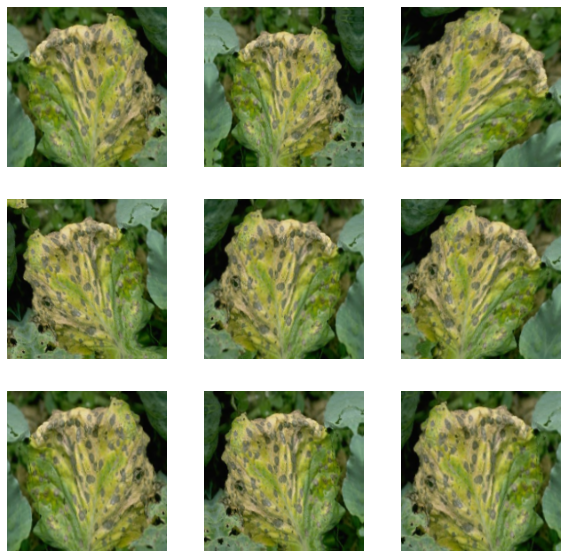

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [21]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
4/4 [==============================] - 1s 47ms/step - loss: 2.0931 - accuracy: 0.2037 - val_loss: 1.8540 - val_accuracy: 0.1923
Epoch 2/15
4/4 [==============================] - 0s 25ms/step - loss: 1.9145 - accuracy: 0.2222 - val_loss: 1.9627 - val_accuracy: 0.1538
Epoch 3/15
4/4 [==============================] - 0s 25ms/step - loss: 1.8009 - accuracy: 0.2778 - val_loss: 1.7860 - val_accuracy: 0.1923
Epoch 4/15
4/4 [==============================] - 0s 26ms/step - loss: 1.7130 - accuracy: 0.2778 - val_loss: 1.6749 - val_accuracy: 0.2308
Epoch 5/15
4/4 [==============================] - 0s 25ms/step - loss: 1

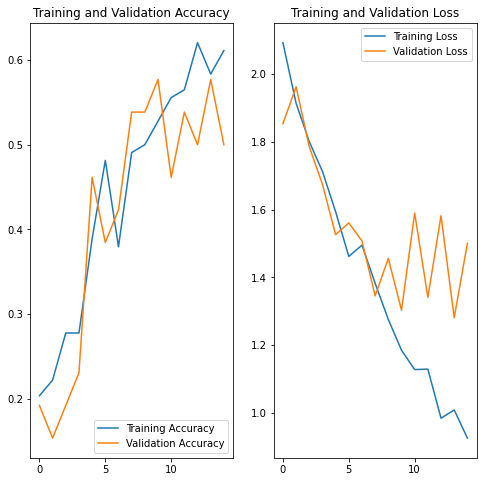

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
lettuce_path = "C:\\Users\\USER\\Desktop\\bacterial_sample0.jpg"
# sunflower_path = tf.keras.utils.get_file('sick_lettuce', origin=sunflower_url)

img = tf.keras.utils.load_img(
    lettuce_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

ind = np.argpartition(score, -7)[-7:]

print("All predictions:")
print('-------------------------\n')
sum = 0
pred_list = []

for el in ind:
  pred = [ class_names[el] ,  float(100 * score[el]) ]
  sum += float(100 * score[el])
  pred_list.append(pred)
  # tf.print(score[el]*100)

pred_list = sorted(pred_list, key = lambda x: x[1])

for pred in pred_list:
  print(pred[0], ' : ', pred[1])

print('\nTotal sum of : ', sum)



This image most likely belongs to bacterial with a 58.55 percent confidence.
All predictions:
-------------------------

healthy  :  0.009680565446615219
viral  :  1.050554633140564
fungal_downy_mildew  :  1.637345552444458
fungal_wilt_and_leaf_blight  :  2.055999755859375
fungal_septoria_blight  :  9.1391019821167
fungal_powdery_mildew  :  27.56084442138672
bacterial  :  58.54646682739258

Total sum of :  99.99999373778701
